# Step 0: Load train and test data from CSV

In [1]:
#Laden der McDonald's Aktie in Notebook.
import pandas as pd
import numpy as np

df = pd.read_csv("MDO.DE.csv", index_col="Date", parse_dates=True).dropna()

number_of_test_samples = 14

df_train = df.iloc[:-number_of_test_samples, 3]
df_test = df.iloc[-number_of_test_samples:, 3]

## Display data Info

In [2]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-07-17,262.700012,264.299988,262.100006,264.100006,264.100006,1811.0
2023-07-18,262.100006,263.399994,260.799988,262.600006,262.600006,2328.0
2023-07-19,262.500000,263.299988,261.299988,262.200012,262.200012,2042.0
2023-07-20,262.000000,266.399994,261.700012,265.899994,265.899994,1499.0
2023-07-21,266.899994,268.600006,266.200012,267.399994,267.399994,2478.0


## Plot loaded training data

<AxesSubplot:xlabel='Date'>

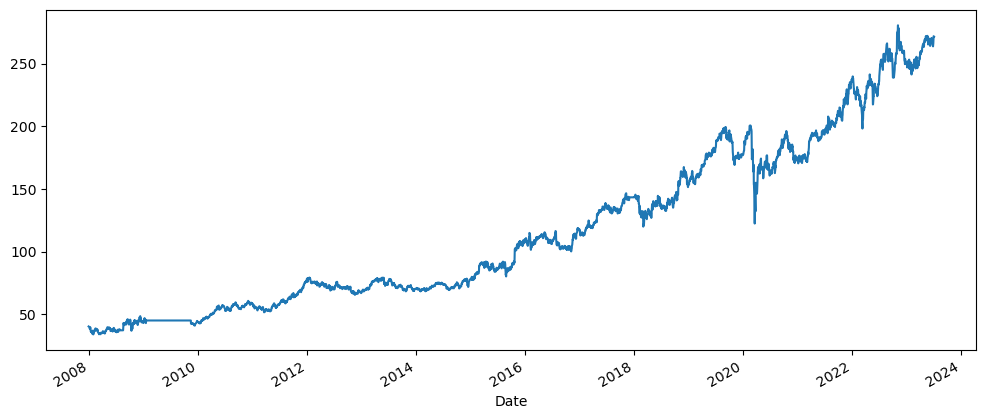

In [3]:
df_train.plot(figsize=(12,5))

# Step 1: Check for stationary of time series and transform if necessary

In [4]:
#Mithilfe des ADF-Tests auf Stationarität prüfen.
from statsmodels.tsa.stattools import adfuller

def run_adf_test(data_frame):
        adf, pvalue, usedlag, nobs, critical_values, _ = adfuller(data_frame)

        new_line = "\n\t\t"
        print(f"""
        1. ADF: {adf}
        2. P-Value: {pvalue}
        3. Num of Lags: {usedlag}
        4. Num of Observations used for ADF Regression and critical values calculation: {nobs}
        5. Critical Values: 
                {new_line.join([f"{key}: {val}" for key, val in critical_values.items()])}
        """)

adf_test_data = df_train

run_adf_test(adf_test_data)


        1. ADF: 0.9068136504086034
        2. P-Value: 0.9931786051590589
        3. Num of Lags: 31
        4. Num of Observations used for ADF Regression and critical values calculation: 3903
        5. Critical Values: 
                1%: -3.4320265580345004
		5%: -2.8622808115385583
		10%: -2.567164342737072
        


```python
# da hier der P-Value größer 0,05 ist -> Zeitreihe NICHT stationär
```

## Transform to stationary: calculating discrete difference

### Check how many times to differentiat using ndiff method

In [5]:
from pmdarima.arima.utils import ndiffs
ndiffs(df_train, test="adf")
# hiermit lässt sich noch einmal überprüfen wie häufig das ursprüngliche Dataframe differenziert werden soll

1

### Discreetly differentiat data

In [6]:
df_train_diffed = df_train.diff().dropna()
df_test_diffed = df_test.diff().dropna()

### Plot discrete difference

<AxesSubplot:xlabel='Date'>

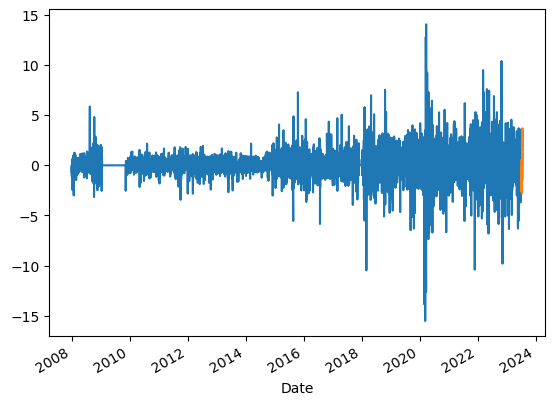

In [7]:
df_train_diffed.plot()
df_test_diffed.plot()

### Rerun Adf test to check of differentiation worked

In [8]:
run_adf_test(df_train_diffed)


        1. ADF: -12.162150051761936
        2. P-Value: 1.4851887318391181e-22
        3. Num of Lags: 30
        4. Num of Observations used for ADF Regression and critical values calculation: 3903
        5. Critical Values: 
                1%: -3.4320265580345004
		5%: -2.8622808115385583
		10%: -2.567164342737072
        


```python
# P-Value deutlich kleiner als 0.05, Differenzierung somit erfolgreich durchgeführt
```

# Step 2: Determine ARIMA models parameter p

```python
# aktuelles Modell: ARIMA(p,1,q)
```

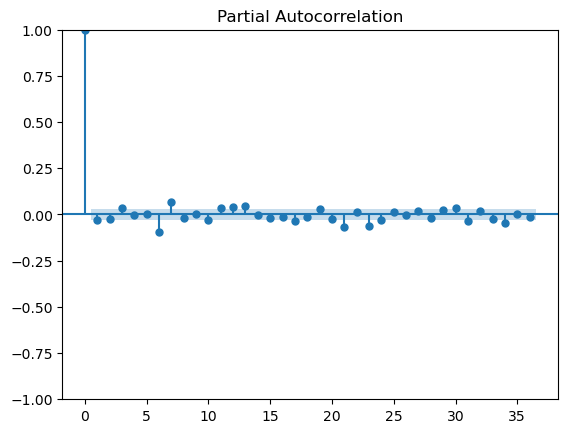

In [9]:
from statsmodels.graphics.tsaplots import plot_pacf

pacf = plot_pacf(df_train_diffed)

```python
# Hier zu erkennen nimmt das AR(p)-Modell den Wert 0 an = AR(0)
```

```python
# aktuelles Modell: ARIMA(0,1,q)
```

# Step 3: Determine ARIMA models parameter q

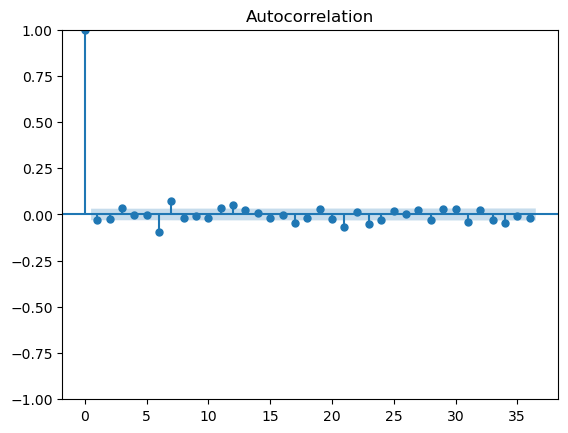

In [10]:
from statsmodels.graphics.tsaplots import plot_acf

acf = plot_acf(df_train_diffed)

```python
# Hier zu erkennen nimmt das MA(q)-Modell den Wert 0 an = MA(0)
# endgültiges Modell: ARIMA(0,1,0)
```

# Step 4: Fit the ARIMA model

In [11]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_train_diffed.reset_index(drop=True), order=(0, 1, 0))
model = model.fit()

## Print model summery

In [12]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3934
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -8900.530
Date:                Tue, 01 Aug 2023   AIC                          17803.060
Time:                        17:52:25   BIC                          17809.337
Sample:                             0   HQIC                         17805.287
                               - 3934                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         5.4097      0.042    129.976      0.000       5.328       5.491
Ljung-Box (L1) (Q):                 995.99   Jarque-Bera (JB):             38134.67
Prob(Q):                              0.00   Pr

## Plot model statistics

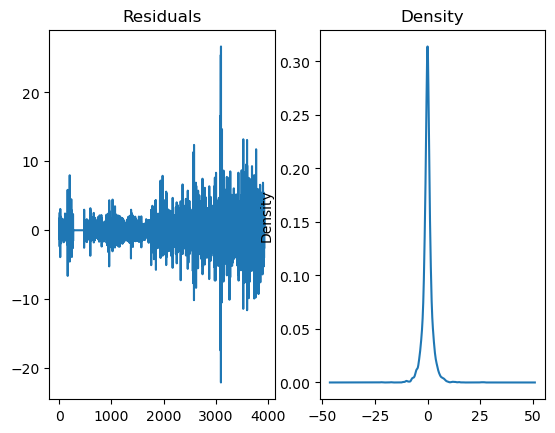

In [13]:
import matplotlib.pyplot as plt

residuals = model.resid[1:]
_, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(title="Density", kind="kde", ax=ax[1])
plt.show()

# Step 5: Make time series prediciton

<AxesSubplot:xlabel='Date'>

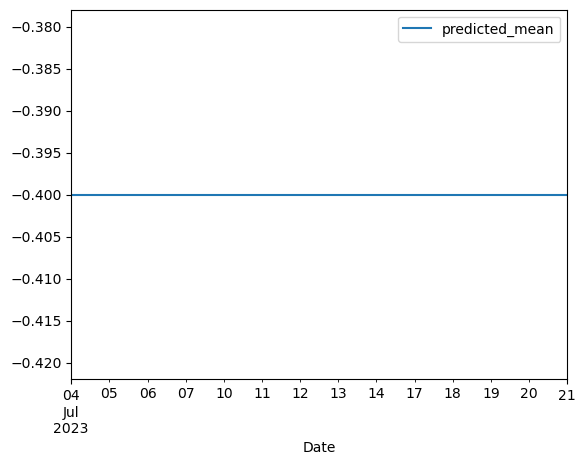

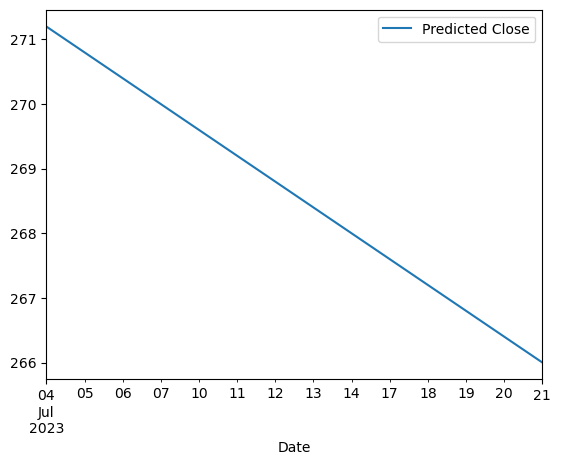

In [14]:
# Sage die nächsten werte differenziert vorher
prediction_diffed = pd.DataFrame(model.forecast(number_of_test_samples))
prediction_diffed.index = df_test.index
prediction_diffed.plot()

# Letzten Wert der originalen Zeitreihe
last_value = df_train.iloc[-1]

prediction = prediction_diffed.cumsum().add(last_value)
prediction.columns = ["Predicted Close"]
prediction.plot()

## Plot predicted close course and actual course

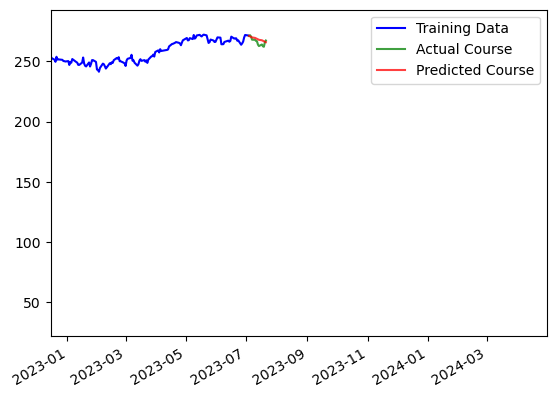

In [15]:
#Plotten der abgespeicherten DataFrames
import matplotlib.pyplot as plt

plt.plot(df_train.index, df_train, color="blue", label="Training Data",)
plt.plot(df_test.index, df_test, color="green", alpha=0.75, label="Actual Course")
plt.plot(prediction.index, prediction, color="red", alpha=0.75, label="Predicted Course")

#zoom_level legt fest, ab welchem Index-Wert geplottet werden soll, da sonst zu undeutig.
zoom_level = 3800 # max: len(df)

plt.xlim(df.index[zoom_level])
plt.gcf().autofmt_xdate()

plt.legend()
plt.show()